In [2]:
import cv2
def denoise_image(src_path, dest_path):
    # Load the image
    image = cv2.imread(src_path, cv2.IMREAD_GRAYSCALE)
    
    # Verify image load
    if image is None:
        print("Error: Image not found.")
        return
    
    # Fourier transform
    frequency_transform = np.fft.fft2(image)
    frequency_shifted = np.fft.fftshift(frequency_transform)
    
    # Spectrum magnitude
    spectrum = np.log(np.abs(frequency_shifted) + 1) * 20
    normalized_spectrum = cv2.normalize(spectrum, None, 0, 255, cv2.NORM_MINMAX)
    
    # Display the magnitude spectrum
    plt.figure()
    plt.title("Before Filtering - Magnitude Spectrum")
    plt.imshow(normalized_spectrum, cmap='gray')
    plt.show()

    # Image dimensions
    height, width = image.shape
    center_y, center_x = height // 2, width // 2
    
    # Masking
    mask = np.ones((height, width), bool)  # Use built-in bool type
    exclusion_zone = min(height, width) // 8
    mask[center_y - exclusion_zone:center_y + exclusion_zone, center_x - exclusion_zone:center_x + exclusion_zone] = False
    frequency_shifted[mask] = 0
    
    # Spectrum after filtering
    spectrum_filtered = np.log(np.abs(frequency_shifted) + 1) * 20
    normalized_spectrum_filtered = cv2.normalize(spectrum_filtered, None, 0, 255, cv2.NORM_MINMAX)
    plt.figure()
    plt.title("After Filtering - Magnitude Spectrum")
    plt.imshow(normalized_spectrum_filtered, cmap='gray')
    plt.show()

    # Inverse Fourier transform
    inverse_frequency_shift = np.fft.ifftshift(frequency_shifted)
    restored_image = np.abs(np.fft.ifft2(inverse_frequency_shift))
    
    # Display original image
    plt.figure()
    plt.title("Original Image")
    plt.imshow(image, cmap='gray')
    plt.show()
    
    # Display denoised image
    plt.figure()
    plt.title("Denoised Image")
    plt.imshow(restored_image, cmap='gray')
    plt.show()

    # Save the denoised image
    cv2.imwrite(dest_path, np.uint8(restored_image))

# Execute the function with input and output paths
denoise_image(r'C:\Users\DOCTOR\Desktop\COMP9517\Project1\IMAGE\cell0058.png', 'path_to_output_image.jpg')


NameError: name 'np' is not defined

In [ ]:
#not correct for csv, delete it change use txt file（这个csv版本的有问题，我直接删了换txt文件，excel文件似乎根本读取不了MZ）
import cv2
import os
import numpy as np
import pandas as pd

def process_image(input_image_path, output_dir_with_line, output_dir_without_line):
    # Load image
    def load_image(path):
        img = cv2.imread(path)
        if img is None:
            print("Image Cant upload。")
            return None
        return img

    # Detection black line
    def detect_black_line(img):
        row_slice = img[40:55, :]
        sobel_x = cv2.Sobel(row_slice, cv2.CV_64F, 1, 0, ksize=3)
        sobel_y = cv2.Sobel(row_slice, cv2.CV_64F, 0, 1, ksize=3)
        gradient_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
        _, otsu_thresh = cv2.threshold((gradient_magnitude * 255.0 / gradient_magnitude.max()).astype(np.uint8), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        return np.any(gradient_magnitude > otsu_thresh)

    # Remove image section
    def remove_section(img, with_line):
        if with_line:
            parts = [img[:45, :], img[60:140, :], img[155:240, :], img[255:, :]]
        else:
            parts = [img[:70, :], img[85:210, :], img[225:, :]]
        return np.vstack(parts)

    # Main processing flow
    image = load_image(input_image_path)
    if image is not None:
        has_line = detect_black_line(image)
        new_image = remove_section(image, has_line)
        if has_line:
            output_path = os.path.join(output_dir_with_line, os.path.basename(input_image_path))
        else:
            output_path = os.path.join(output_dir_without_line, os.path.basename(input_image_path))
        cv2.imwrite(output_path, new_image)

# Create output directory
os.makedirs('processed_images_with_line', exist_ok=True)
os.makedirs('processed_images_without_line', exist_ok=True)

# Read CSV files and process images
df = pd.read_csv('Final_labels.csv')
for index, row in df.iterrows():
    img_path = row[0]
    print(img_path)
    full_img_path = os.path.join(os.getcwd(), img_path)
    process_image(full_img_path, 'processed_images_with_line', 'processed_images_without_line')

print('Process Complete！')


In [3]:
#Another version of document reading and writing
def get_training_data():
    csv_filepath = "place_holder" # csv file path
    training_data = []
    training_data_limit = 2000
    with open(csv_filepath, mode="r") as csv_file:
        reader = csv.reader(csv_file)
        next(reader) # skip the first row
        # process each row
        for row in reader:
            if training_data_limit > 0:
                image = cv2.imread(row[0]) # load image
                resized_image = cv2.resize(image,(200,200)) # resize image
                damage_rate = float(row[1]) # get the damage rate
                training_data.append((resized_image, damage_rate))
                training_data_limit -= 1
            else:
                pass

    return training_data

In [4]:
import os
import cv2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# Set the directory where the data is stored
data_directory = "C:\\Users\\DOCTOR\\Desktop\\ALL_images\\"

# Define the mapping from numeric labels to categories
categories = {
    0.0: "normal",
    0.333333333: "0.3Break",
    0.666666667: "0.6Break",
    1.0: "TotalBreak"
}

# Load the label information from a text file
label_info = pd.read_csv(
    "C:\\Users\\DOCTOR\\Desktop\\ALL_images\\labels.txt",
    delimiter='\t',
    header=None,
    names=['image_path', 'label_value', 'image_type']
)

# Convert numeric labels to string labels
label_info['label'] = label_info['label_value'].map(categories)

# Initialize list for all images and labels
image_data = []

# Process each image and label
for index, record in label_info.iterrows():
    full_image_path = os.path.join(data_directory, record['image_path'])
    image_label = record['label']

    try:
        image = cv2.imread(full_image_path, cv2.IMREAD_GRAYSCALE)
        if image is not None:
            resized_image = cv2.resize(image, (200, 200))
            image_data.append((resized_image, image_label))
        else:
            print(f"Cannot load image at {full_image_path}.")
    except Exception as error:
        print(f"Error processing image at {full_image_path}: {error}")

# Split the data into training and testing sets (80% train, 20% test)
training_set, testing_set = train_test_split(image_data, test_size=0.2, random_state=42)

# Create mappings for categories to indices
category_indices = {category: idx for idx, category in enumerate(categories.values())}

# Prepare the training and testing datasets
X_train, Y_train_indices = zip(*[(img, category_indices[lab]) for img, lab in training_set])
X_test, Y_test_indices = zip(*[(img, category_indices[lab]) for img, lab in testing_set])

# Convert to numpy arrays and normalize
X_train = np.array(X_train).reshape(-1, 200, 200, 1) / 255.0
X_test = np.array(X_test).reshape(-1, 200, 200, 1) / 255.0

# Convert labels to one-hot encoding
Y_train = to_categorical(Y_train_indices, num_classes=len(categories))
Y_test = to_categorical(Y_test_indices, num_classes=len(categories))

# Print some training labels to ensure the one-hot encoding is correct
print("Sample one-hot encoded training labels:")
for one_hot_label in Y_train[10:20]:
    print(one_hot_label)

# The corresponding categories are as follows:
# [1. 0. 0. 0.] corresponds to "normal"
# [0. 1. 0. 0.] corresponds to "0.3Break"
# [0. 0. 1. 0.] corresponds to "0.6Break"
# [0. 0. 0. 1.] corresponds to "TotalBreak"


Sample one-hot encoded training labels:
[0. 0. 0. 1.]
[0. 1. 0. 0.]
[1. 0. 0. 0.]
[0. 0. 0. 1.]
[1. 0. 0. 0.]
[0. 0. 1. 0.]
[1. 0. 0. 0.]
[1. 0. 0. 0.]
[0. 0. 0. 1.]
[0. 0. 0. 1.]


In [7]:
from sklearn.metrics import confusion_matrix
import itertools
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation, Dropout



model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='Same', activation='relu', input_shape=(200,200,1)))
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='Same', activation='relu'))
model.add(MaxPool2D((2,2),strides=(2,2)))
model.add(Conv2D(filters=16, kernel_size=(3,3), padding='Same', activation='relu'))
model.add(MaxPool2D((2,2),strides=(2,2)))
model.add(Conv2D(filters=8, kernel_size=(3,3), padding='Same', activation='relu'))


model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(4, activation='sigmoid'))
optimizer = Adam(learning_rate=0.00003, beta_1=0.85, beta_2=0.95)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

# Not always useful but another method
#model = Sequential([
#     # Convolutional layers with batch normalization and ReLU activation
#     Conv2D(filters=8, kernel_size=(3,3), padding='same', input_shape=(200,200,1)),
#     BatchNormalization(),
#     Activation('relu'),
    
#     Conv2D(filters=16, kernel_size=(3,3), padding='same'),
#     BatchNormalization(),
#     Activation('relu'),
    
#     MaxPooling2D(pool_size=(2,2), strides=2),
    
#     Conv2D(filters=32, kernel_size=(3,3), padding='same'),
#     BatchNormalization(),
#     Activation('relu'),
    
#     # Dropout layer
#     Dropout(0.25),
    
#     # Flatten layer to prepare for the fully connected layers
#     Flatten(),
    
#     # Fully connected layers
#     Dense(9, activation='relu'),
#     # The following layer is commented out to match the MATLAB example where it's not active
#     # Dense(1000, activation='relu'),
    
#     # Output layer with softmax activation
#     Dense(4, activation='sigmoid')
# ])

epochs = 10
batch_size = 15

datagen = ImageDataGenerator(
        featurewise_center=False, 
        samplewise_center=False, 
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,  
        zca_whitening=False,
        rotation_range=0.5, # Changed the rotation range
        zoom_range = 0.5, 
        width_shift_range=0.2,  # Adjusted the width shift range
        height_shift_range=0.2,  # Adjusted the height shift range
        horizontal_flip=False, 
        vertical_flip=False)

In [11]:
from keras.callbacks import ModelCheckpoint

# Save model
checkpoint = ModelCheckpoint('model-{epoch:03d}.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')

# ADD fit TO callbacks Index
history = model.fit(datagen.flow(X_train, Y_train, batch_size=batch_size),
                    epochs=epochs, 
                    validation_data=(X_test, Y_test), 
                    steps_per_epoch=X_train.shape[0] // batch_size,
                    callbacks=[checkpoint])


Epoch 1/10
139/139 [==============================] - ETA: 0s - loss: 1.0571 - accuracy: 0.5729
Epoch 1: val_loss improved from inf to 1.03712, saving model to model-001.h5
139/139 [==============================] - 52s 371ms/step - loss: 1.0571 - accuracy: 0.5729 - val_loss: 1.0371 - val_accuracy: 0.5829
Epoch 2/10


C:\Users\DOCTOR\anaconda3\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


139/139 [==============================] - ETA: 0s - loss: 1.0425 - accuracy: 0.5729
Epoch 2: val_loss did not improve from 1.03712
139/139 [==============================] - 51s 366ms/step - loss: 1.0425 - accuracy: 0.5729 - val_loss: 1.0516 - val_accuracy: 0.5829
Epoch 3/10
139/139 [==============================] - ETA: 0s - loss: 1.0425 - accuracy: 0.5763
Epoch 3: val_loss improved from 1.03712 to 1.01423, saving model to model-003.h5
139/139 [==============================] - 51s 369ms/step - loss: 1.0425 - accuracy: 0.5763 - val_loss: 1.0142 - val_accuracy: 0.5886
Epoch 4/10
139/139 [==============================] - ETA: 0s - loss: 1.0295 - accuracy: 0.5797
Epoch 4: val_loss improved from 1.01423 to 0.99997, saving model to model-004.h5
139/139 [==============================] - 52s 373ms/step - loss: 1.0295 - accuracy: 0.5797 - val_loss: 1.0000 - val_accuracy: 0.5924
Epoch 5/10
139/139 [==============================] - ETA: 0s - loss: 1.0145 - accuracy: 0.6027
Epoch 5: val_los

17/17 [==============================] - 2s 108ms/step


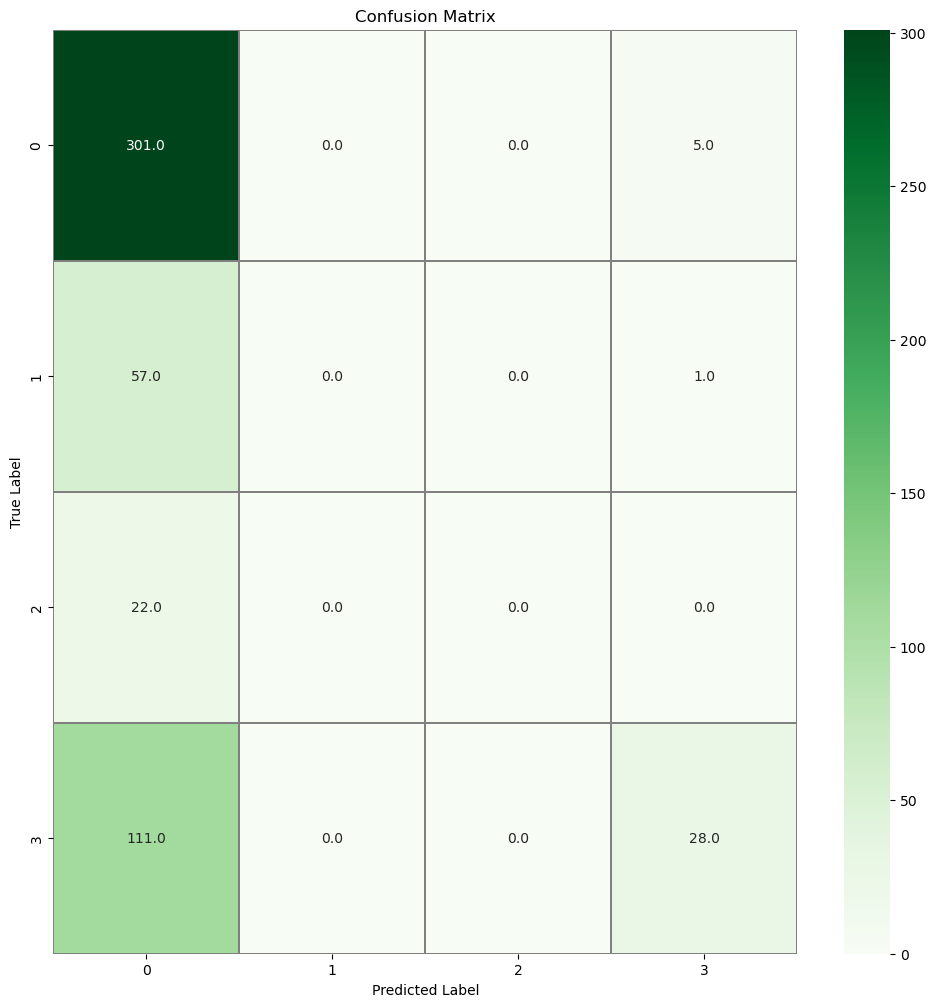

17/17 [==============================] - 2s 115ms/step
Test loss : 0.9542035460472107
Test Accuracy :  0.6266666650772095


In [18]:
#pip install seaborn
import matplotlib.pyplot as plt
import seaborn as sns
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred,axis = 1) 
y_true = np.argmax(Y_test,axis = 1) 
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

predictions = model.predict(X_test)
score = model.evaluate(X_test,Y_test,verbose=0)
print("Test loss :",score[0])
print("Test Accuracy : ",score[1])